## Hipothesis

Printers usually behave inside expected parameters, so extreme values should be rare in comparison.

In [1]:
library(dplyr)
library(purrr)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘purrr’

The following object is masked from ‘package:dplyr’:

    order_by



In [2]:
load('IndigoData.dat')
data_ps <- data %>% filter(event_state == "PRINT_STATE")

## Ratio of events that fall within the thresholds

In [3]:
data_ps %>% 
select(PIP_Temperature, IO_temperature, CS_Voltage, vessel_flow, IO_dirtiness, IO_Conductivity, Delta_Pressure) %>%
summarise_each(funs(NAs = round(sum(is.na(.)) / n(), 2)))

data_ps %>% 
select(PIP_Temperature, IO_temperature, CS_Voltage, vessel_flow, IO_dirtiness, IO_Conductivity, Delta_Pressure) %>%
summarise_each(funs(events = round(sum(!is.na(.)) / n(), 2)))

,PIP_Temperature,IO_temperature,CS_Voltage,vessel_flow,IO_dirtiness,IO_Conductivity,Delta_Pressure
1,0.00,0.00,0.00,0.10,0.00,0.49,0.00


,PIP_Temperature,IO_temperature,CS_Voltage,vessel_flow,IO_dirtiness,IO_Conductivity,Delta_Pressure
1,1.00,1.00,1.00,0.90,1.00,0.51,1.00


Summary of the data shows that vessel_flow and IO_Conductivity have a lot of missing values. This changes somewhat if we group by Product Line.

In [4]:
data_ps %>% 
group_by(Product_Line) %>%
select(PIP_Temperature, IO_temperature, CS_Voltage, vessel_flow, IO_dirtiness, IO_Conductivity, Delta_Pressure) %>%
summarise_each(funs(NAs = round(sum(is.na(.)) / n(), 2)))

data_ps %>% 
group_by(Product_Line) %>%
select(PIP_Temperature, IO_temperature, CS_Voltage, vessel_flow, IO_dirtiness, IO_Conductivity, Delta_Pressure) %>%
summarise_each(funs(events = round(sum(!is.na(.)) / n(), 2)))

,Product_Line,PIP_Temperature,IO_temperature,CS_Voltage,vessel_flow,IO_dirtiness,IO_Conductivity,Delta_Pressure
1,HP Indigo 7000,0,0,0,0.15,0,1,0
2,HP Indigo 7500,0,0,0,0.15,0,0.72,0
3,HP Indigo 7600,0,0,0,0.03,0,0.01,0


,Product_Line,PIP_Temperature,IO_temperature,CS_Voltage,vessel_flow,IO_dirtiness,IO_Conductivity,Delta_Pressure
1,HP Indigo 7000,1,1,1,0.85,1,0,1
2,HP Indigo 7500,1,1,1,0.85,1,0.28,1
3,HP Indigo 7600,1,1,1,0.97,1,0.99,1


We can see that IO_Conductivity is not present at all for the 7000 product line.

According to Niv Cohen's report these are the threshold we do have for 7xxx Indigo printers:
- PIP Temperature: 250 <= x <= 350
- IO Temperature\*: 250 <= x <= 350
- CS Voltage: 1900 <= x <= 2400
- Vessel Flow: 3800 <= x <= 4800
- IO Conductivity: 2 < x <= 10

\*these thresholds for IO Temperature does not seem correct (They were never mentioned in the original report, but alluded to on the email referring to the the report). Data shows a slight discrepancy. 

In [5]:
data_summarized <- data_ps %>% summarise(PIP_Temperature.normal = sum(PIP_Temperature >= 250 & PIP_Temperature <= 350, na.rm = T),
                      PIP_Temperature.ratio.all = PIP_Temperature.normal / n(),
                      PIP_Temperature.ratio.non.na = PIP_Temperature.normal / sum(!is.na(PIP_Temperature)),
                      IO_temperature.normal = sum(IO_temperature >= 250 & IO_temperature <= 350, na.rm = T),
                      IO_temperature.ratio.all = IO_temperature.normal / n(),
                      IO_temperature.ratio.non.na = IO_temperature.normal / sum(!is.na(IO_temperature)),
                      CS_Voltage.normal = sum(CS_Voltage >= 1900 & CS_Voltage <= 2400, na.rm = T),
                      CS_Voltage.ratio.all = CS_Voltage.normal / n(),
                      CS_Voltage.ratio.non.na = CS_Voltage.normal / sum(!is.na(CS_Voltage)),
                      Vessel_flow.normal = sum(vessel_flow >= 3800 & vessel_flow <= 4600, na.rm = T),
                      Vessel_flow.ratio.all = Vessel_flow.normal / n(),
                      Vessel_flow.ratio.non.na = Vessel_flow.normal / sum(!is.na(vessel_flow)),
                      IO_Conductivity.normal = sum(IO_Conductivity > 2 & IO_Conductivity <= 10, na.rm = T),
                      IO_Conductivity.ratio.all = IO_Conductivity.normal / n(),
                      IO_Conductivity.ratio.non.na = IO_Conductivity.normal / sum(!is.na(IO_Conductivity)))

### Ratio of events that fall within thresholds taken into considaration all events


In [6]:
data_summarized %>% select(ends_with("ratio.all")) %>% mutate_each(funs(round(.,2))) %>% t()


PIP_Temperature.ratio.all,0.97
IO_temperature.ratio.all,0.6
CS_Voltage.ratio.all,0.64
Vessel_flow.ratio.all,0.69
IO_Conductivity.ratio.all,0.47


Given that of all the events we don't have any missing values for IO Temperature, it's abit strange that 40% of the data fall outside the threashold values, if the assumption is that IO temperature follows PIP temperature measurements. They are correlated, though.

The same seems to be so for CS Voltage, we don't have any missing value for the events we do have, and yet a large portion of it falls outside the thresholds. While we do have some missing values for vessel flow, there's a large portion of the values we do have outside the threshold limtis.

IO Conductivity shows a large gap as well, but as we will show later this is mostly due to printers of the 7000 product line not have these values.

### Ratio of events that fall within thresholds taken into account only non missing values

In [7]:
data_summarized %>% select(ends_with("ratio.non.na")) %>% mutate_each(funs(round(.,2))) %>% t()


PIP_Temperature.ratio.non.na,0.97
IO_temperature.ratio.non.na,0.6
CS_Voltage.ratio.non.na,0.64
Vessel_flow.ratio.non.na,0.76
IO_Conductivity.ratio.non.na,0.91


So for the values we do have, discounting any of missing values, we see that IO Conductivity goes up, while the rest maintains the discrepancy described above.

### Ratio of events that fall within thresholds grouping by product line


In [8]:
data_summarized_pruduct_line <- data_ps %>% 
                   group_by(Product_Line) %>%
                   summarise(PIP_Temperature.normal = sum(PIP_Temperature >= 250 & PIP_Temperature <= 350, na.rm = T),
                      PIP_Temperature.ratio.all = PIP_Temperature.normal / n(),
                      PIP_Temperature.ratio.non.na = PIP_Temperature.normal / sum(!is.na(PIP_Temperature)),
                      IO_temperature.normal = sum(IO_temperature >= 250 & IO_temperature <= 350, na.rm = T),
                      IO_temperature.ratio.all = IO_temperature.normal / n(),
                      IO_temperature.ratio.non.na = IO_temperature.normal / sum(!is.na(IO_temperature)),
                      CS_Voltage.normal = sum(CS_Voltage >= 1900 & CS_Voltage <= 2400, na.rm = T),
                      CS_Voltage.ratio.all = CS_Voltage.normal / n(),
                      CS_Voltage.ratio.non.na = CS_Voltage.normal / sum(!is.na(CS_Voltage)),
                      Vessel_flow.normal = sum(vessel_flow >= 3800 & vessel_flow <= 4600, na.rm = T),
                      Vessel_flow.ratio.all = Vessel_flow.normal / n(),
                      Vessel_flow.ratio.non.na = Vessel_flow.normal / sum(!is.na(vessel_flow)),
                      IO_Conductivity.normal = sum(IO_Conductivity > 2 & IO_Conductivity <= 10, na.rm = T),
                      IO_Conductivity.ratio.all = IO_Conductivity.normal / n(),
                      IO_Conductivity.ratio.non.na = IO_Conductivity.normal / sum(!is.na(IO_Conductivity)),
                      IO_dirtiness.normal = sum(IO_dirtiness < 900, na.rm = T), #Not official...
                      IO_dirtiness.ratio.all = IO_dirtiness.normal / n(),
                      IO_dirtiness.ratio.non.na = IO_dirtiness.normal / sum(!is.na(IO_dirtiness)))

In [9]:
data_summarized_pruduct_line %>% select(Product_Line, ends_with("ratio.all")) %>% mutate_each(funs(round(.,2)), -Product_Line) %>% t()
data_summarized_pruduct_line %>% select(Product_Line, ends_with("ratio.non.na")) %>% mutate_each(funs(round(.,2)), -Product_Line) %>% t()

Product_Line,HP Indigo 7000,HP Indigo 7500,HP Indigo 7600
PIP_Temperature.ratio.all,0.97,0.96,0.97
IO_temperature.ratio.all,0.79,0.56,0.52
CS_Voltage.ratio.all,0.64,0.70,0.59
Vessel_flow.ratio.all,0.62,0.61,0.79
IO_Conductivity.ratio.all,0.00,0.26,0.90
IO_dirtiness.ratio.all,0.76,0.68,0.48


Product_Line,HP Indigo 7000,HP Indigo 7500,HP Indigo 7600
PIP_Temperature.ratio.non.na,0.97,0.96,0.97
IO_temperature.ratio.non.na,0.79,0.56,0.52
CS_Voltage.ratio.non.na,0.64,0.70,0.59
Vessel_flow.ratio.non.na,0.73,0.72,0.81
IO_Conductivity.ratio.non.na,NA,0.92,0.91
IO_dirtiness.ratio.non.na,0.76,0.68,0.48


Grouping by Product Line we can see that IO temperature get closer to what would be expected if the thresholds determine normal behavior and the printers mostly display normal behavior for the 7000 product line. It also mean that for the other product lines it does not seem to be good.

The HP Indigo 7500 has alot of missing values for IO Conductivity so much so that only about a quarter of the events have values.



In [10]:
data_summarized_event_press_7000 <- data_ps %>% 
                   filter(Product_Line == "HP Indigo 7000") %>%
                   group_by(event_press) %>%
                   summarise(PIP_Temperature.normal = sum(PIP_Temperature >= 250 & PIP_Temperature <= 350, na.rm = T),
                      PIP_Temperature.ratio.all = PIP_Temperature.normal / n(),
                      PIP_Temperature.ratio.non.na = PIP_Temperature.normal / sum(!is.na(PIP_Temperature)),
                      IO_temperature.normal = sum(IO_temperature >= 250 & IO_temperature <= 350, na.rm = T),
                      IO_temperature.ratio.all = IO_temperature.normal / n(),
                      IO_temperature.ratio.non.na = IO_temperature.normal / sum(!is.na(IO_temperature)),
                      CS_Voltage.normal = sum(CS_Voltage >= 1900 & CS_Voltage <= 2400, na.rm = T),
                      CS_Voltage.ratio.all = CS_Voltage.normal / n(),
                      CS_Voltage.ratio.non.na = CS_Voltage.normal / sum(!is.na(CS_Voltage)),
                      Vessel_flow.normal = sum(vessel_flow >= 3800 & vessel_flow <= 4600, na.rm = T),
                      Vessel_flow.ratio.all = Vessel_flow.normal / n(),
                      Vessel_flow.ratio.non.na = Vessel_flow.normal / sum(!is.na(vessel_flow)),
                      IO_Conductivity.normal = sum(IO_Conductivity > 2 & IO_Conductivity <= 10, na.rm = T),
                      IO_Conductivity.ratio.all = IO_Conductivity.normal / n(),
                      IO_Conductivity.ratio.non.na = IO_Conductivity.normal / sum(!is.na(IO_Conductivity)),
                      IO_dirtiness.normal = sum(IO_dirtiness < 900, na.rm = T),
                      IO_dirtiness.ratio.all = IO_dirtiness.normal / n(),
                      IO_dirtiness.ratio.non.na = IO_dirtiness.normal / sum(!is.na(IO_dirtiness))) %>% 
                   mutate(Product_Line = "HP Indigo 7000")
data_summarized_event_press_7500 <- data_ps %>% 
                   filter(Product_Line == "HP Indigo 7500") %>%
                   group_by(event_press) %>%
                   summarise(PIP_Temperature.normal = sum(PIP_Temperature >= 250 & PIP_Temperature <= 350, na.rm = T),
                      PIP_Temperature.ratio.all = PIP_Temperature.normal / n(),
                      PIP_Temperature.ratio.non.na = PIP_Temperature.normal / sum(!is.na(PIP_Temperature)),
                      IO_temperature.normal = sum(IO_temperature >= 250 & IO_temperature <= 350, na.rm = T),
                      IO_temperature.ratio.all = IO_temperature.normal / n(),
                      IO_temperature.ratio.non.na = IO_temperature.normal / sum(!is.na(IO_temperature)),
                      CS_Voltage.normal = sum(CS_Voltage >= 1900 & CS_Voltage <= 2400, na.rm = T),
                      CS_Voltage.ratio.all = CS_Voltage.normal / n(),
                      CS_Voltage.ratio.non.na = CS_Voltage.normal / sum(!is.na(CS_Voltage)),
                      Vessel_flow.normal = sum(vessel_flow >= 3800 & vessel_flow <= 4600, na.rm = T),
                      Vessel_flow.ratio.all = Vessel_flow.normal / n(),
                      Vessel_flow.ratio.non.na = Vessel_flow.normal / sum(!is.na(vessel_flow)),
                      IO_Conductivity.normal = sum(IO_Conductivity > 2 & IO_Conductivity <= 10, na.rm = T),
                      IO_Conductivity.ratio.all = IO_Conductivity.normal / n(),
                      IO_Conductivity.ratio.non.na = IO_Conductivity.normal / sum(!is.na(IO_Conductivity)),
                      IO_dirtiness.normal = sum(IO_dirtiness < 900, na.rm = T),
                      IO_dirtiness.ratio.all = IO_dirtiness.normal / n(),
                      IO_dirtiness.ratio.non.na = IO_dirtiness.normal / sum(!is.na(IO_dirtiness))) %>% 
                   mutate(Product_Line = "HP Indigo 7500")
data_summarized_event_press_7600 <- data_ps %>% 
                   filter(Product_Line == "HP Indigo 7600") %>%
                   group_by(event_press) %>%
                   summarise(PIP_Temperature.normal = sum(PIP_Temperature >= 250 & PIP_Temperature <= 350, na.rm = T),
                      PIP_Temperature.ratio.all = PIP_Temperature.normal / n(),
                      PIP_Temperature.ratio.non.na = PIP_Temperature.normal / sum(!is.na(PIP_Temperature)),
                      IO_temperature.normal = sum(IO_temperature >= 250 & IO_temperature <= 350, na.rm = T),
                      IO_temperature.ratio.all = IO_temperature.normal / n(),
                      IO_temperature.ratio.non.na = IO_temperature.normal / sum(!is.na(IO_temperature)),
                      CS_Voltage.normal = sum(CS_Voltage >= 1900 & CS_Voltage <= 2400, na.rm = T),
                      CS_Voltage.ratio.all = CS_Voltage.normal / n(),
                      CS_Voltage.ratio.non.na = CS_Voltage.normal / sum(!is.na(CS_Voltage)),
                      Vessel_flow.normal = sum(vessel_flow >= 3800 & vessel_flow <= 4600, na.rm = T),
                      Vessel_flow.ratio.all = Vessel_flow.normal / n(),
                      Vessel_flow.ratio.non.na = Vessel_flow.normal / sum(!is.na(vessel_flow)),
                      IO_Conductivity.normal = sum(IO_Conductivity > 2 & IO_Conductivity <= 10, na.rm = T),
                      IO_Conductivity.ratio.all = IO_Conductivity.normal / n(),
                      IO_Conductivity.ratio.non.na = IO_Conductivity.normal / sum(!is.na(IO_Conductivity)),
                      IO_dirtiness.normal = sum(IO_dirtiness < 900, na.rm = T),
                      IO_dirtiness.ratio.all = IO_dirtiness.normal / n(),
                      IO_dirtiness.ratio.non.na = IO_dirtiness.normal / sum(!is.na(IO_dirtiness))) %>% 
                   mutate(Product_Line = "HP Indigo 7600")

data_summarized_event_press <- rbind(data_summarized_event_press_7000, data_summarized_event_press_7500, data_summarized_event_press_7600)
data_summarized_event_press %>% 
                   select(ends_with("ratio.non.na")) %>% 
                   summarise_each(funs(ratio = sum(. > 0.9, na.rm = T)/n())) %>% t()

data_summarized_event_press %>% 
                   group_by(Product_Line) %>%
                   select(Product_Line, ends_with("ratio.non.na")) %>% 
                   summarise_each(funs(ratio = sum(. > 0.9, na.rm = T)/n()), -Product_Line) %>% t()

PIP_Temperature.ratio.non.na,0.9283196
IO_temperature.ratio.non.na,0.3454759
CS_Voltage.ratio.non.na,0.4747356
Vessel_flow.ratio.non.na,0.5287897
IO_Conductivity.ratio.non.na,0.4230317
IO_dirtiness.ratio.non.na,0.5804935


Product_Line,HP Indigo 7000,HP Indigo 7500,HP Indigo 7600
PIP_Temperature.ratio.non.na,0.9561404,0.8902439,0.9363395
IO_temperature.ratio.non.na,0.6271930,0.2235772,0.2546419
CS_Voltage.ratio.non.na,0.5043860,0.5081301,0.4350133
Vessel_flow.ratio.non.na,0.4473684,0.4430894,0.6339523
IO_Conductivity.ratio.non.na,0.0000000,0.2398374,0.7984085
IO_dirtiness.ratio.non.na,0.7719298,0.6016260,0.4509284


The table above shows the ratio of printers out of the 851 printers that have more that 90% of the values for each sensor within spec. Followed by the breakdown by Product Line.


## Summary

For PIP Temperature and, to some extent IO Conductivity for HP Indigo 7600, we see that when we have values most of them fall within the expected limits. That would confirm the hipothesis raised, however, the remaning features have a large portion of events outside the so called normal conditions. 

We, therefore, should be wary when analysing this data for analomalies related to exceeding upper and lower limits.

### Further questions
The thresholds for normal operation in terms of temperature for 7xxx printers were indicated as being between 25ºC and 35º in a report explicitly mentioning PIP temperature. On a related email it was it was suggested that IO temperature would share this threshold, at least above 34ºC; Yet, we can notice that only 62.7% of the events were within these limits for 7000 and only 22,3% and 25.4% of events for printers in the 7500 and 7600 product line, respectively, were within those limits.

This puts into question whether IO Temperature really has the same thresholds, despite being correlated. Or if this only applies to 7000 printers, though not strongly.

## Ratio of values outside the threshold

In [11]:
data_summarized_lh <- data_ps %>% summarise(PIP_Temperature.lower = sum(PIP_Temperature < 250, na.rm = T),
                      PIP_Temperature.lower.ratio.all = PIP_Temperature.lower / n(),
                      PIP_Temperature.lower.ratio.non.na = PIP_Temperature.lower / sum(!is.na(PIP_Temperature)),
                      PIP_Temperature.higher = sum(PIP_Temperature > 350, na.rm = T),
                      PIP_Temperature.higher.ratio.all = PIP_Temperature.higher / n(),
                      PIP_Temperature.higher.ratio.non.na = PIP_Temperature.higher / sum(!is.na(PIP_Temperature)),
                      IO_temperature.lower = sum(IO_temperature < 250, na.rm = T),
                      IO_temperature.lower.ratio.all = IO_temperature.lower / n(),
                      IO_temperature.lower.ratio.non.na = IO_temperature.lower / sum(!is.na(IO_temperature)),
                      IO_temperature.higher = sum(IO_temperature > 350, na.rm = T),
                      IO_temperature.higher.ratio.all = IO_temperature.higher / n(),
                      IO_temperature.higher.ratio.non.na = IO_temperature.higher / sum(!is.na(IO_temperature)),
                      CS_Voltage.lower = sum(CS_Voltage < 1900, na.rm = T),
                      CS_Voltage.lower.ratio.all = CS_Voltage.lower / n(),
                      CS_Voltage.lower.ratio.non.na = CS_Voltage.lower / sum(!is.na(CS_Voltage)),
                      CS_Voltage.higher = sum(CS_Voltage > 2400, na.rm = T),
                      CS_Voltage.higher.ratio.all = CS_Voltage.higher / n(),
                      CS_Voltage.higher.ratio.non.na = CS_Voltage.higher / sum(!is.na(CS_Voltage)),
                      Vessel_flow.lower = sum(vessel_flow < 3800, na.rm = T),
                      Vessel_flow.lower.ratio.all = Vessel_flow.lower / n(),
                      Vessel_flow.lower.ratio.non.na = Vessel_flow.lower / sum(!is.na(vessel_flow)),
                      Vessel_flow.higher = sum(vessel_flow > 4600, na.rm = T),
                      Vessel_flow.higher.ratio.all = Vessel_flow.higher / n(),
                      Vessel_flow.higher.ratio.non.na = Vessel_flow.higher / sum(!is.na(vessel_flow)),
                      IO_Conductivity.lower = sum(IO_Conductivity <= 2, na.rm = T),
                      IO_Conductivity.lower.ratio.all = IO_Conductivity.lower / n(),
                      IO_Conductivity.lower.ratio.non.na = IO_Conductivity.lower / sum(!is.na(IO_Conductivity)),
                      IO_Conductivity.higher = sum(IO_Conductivity > 10, na.rm = T),
                      IO_Conductivity.higher.ratio.all = IO_Conductivity.higher / n(),
                      IO_Conductivity.higher.ratio.non.na = IO_Conductivity.higher / sum(!is.na(IO_Conductivity)))

In [12]:
data_summarized_lh %>% select(ends_with("ratio.all")) %>% mutate_each(funs(round(.,2))) %>% t()
data_summarized_lh %>% select(ends_with("ratio.non.na")) %>% mutate_each(funs(round(.,2))) %>% t()

PIP_Temperature.lower.ratio.all,0
PIP_Temperature.higher.ratio.all,0.03
IO_temperature.lower.ratio.all,0.37
IO_temperature.higher.ratio.all,0.03
CS_Voltage.lower.ratio.all,0.21
CS_Voltage.higher.ratio.all,0.15
Vessel_flow.lower.ratio.all,0.17
Vessel_flow.higher.ratio.all,0.04
IO_Conductivity.lower.ratio.all,0.04
IO_Conductivity.higher.ratio.all,0


PIP_Temperature.lower.ratio.non.na,0
PIP_Temperature.higher.ratio.non.na,0.03
IO_temperature.lower.ratio.non.na,0.37
IO_temperature.higher.ratio.non.na,0.03
CS_Voltage.lower.ratio.non.na,0.21
CS_Voltage.higher.ratio.non.na,0.15
Vessel_flow.lower.ratio.non.na,0.19
Vessel_flow.higher.ratio.non.na,0.04
IO_Conductivity.lower.ratio.non.na,0.08
IO_Conductivity.higher.ratio.non.na,0


We can see that most of the values that fall outside of the thresholds are, in fact, on the lower limit. Only vessel flow and IO conductivity seem somewhat equivalent.

## Ratio of values outside the threshold by product line

In [13]:
data_summarized_lh_product_line <- data_ps %>% 
                      group_by(Product_Line) %>%
                      summarise(PIP_Temperature.lower = sum(PIP_Temperature < 250, na.rm = T),
                      PIP_Temperature.lower.ratio.all = PIP_Temperature.lower / n(),
                      PIP_Temperature.lower.ratio.non.na = PIP_Temperature.lower / sum(!is.na(PIP_Temperature)),
                      PIP_Temperature.higher = sum(PIP_Temperature > 350, na.rm = T),
                      PIP_Temperature.higher.ratio.all = PIP_Temperature.higher / n(),
                      PIP_Temperature.higher.ratio.non.na = PIP_Temperature.higher / sum(!is.na(PIP_Temperature)),
                      IO_temperature.lower = sum(IO_temperature < 250, na.rm = T),
                      IO_temperature.lower.ratio.all = IO_temperature.lower / n(),
                      IO_temperature.lower.ratio.non.na = IO_temperature.lower / sum(!is.na(IO_temperature)),
                      IO_temperature.higher = sum(IO_temperature > 350, na.rm = T),
                      IO_temperature.higher.ratio.all = IO_temperature.higher / n(),
                      IO_temperature.higher.ratio.non.na = IO_temperature.higher / sum(!is.na(IO_temperature)),
                      CS_Voltage.lower = sum(CS_Voltage < 1900, na.rm = T),
                      CS_Voltage.lower.ratio.all = CS_Voltage.lower / n(),
                      CS_Voltage.lower.ratio.non.na = CS_Voltage.lower / sum(!is.na(CS_Voltage)),
                      CS_Voltage.higher = sum(CS_Voltage > 2400, na.rm = T),
                      CS_Voltage.higher.ratio.all = CS_Voltage.higher / n(),
                      CS_Voltage.higher.ratio.non.na = CS_Voltage.higher / sum(!is.na(CS_Voltage)),
                      Vessel_flow.lower = sum(vessel_flow < 3800, na.rm = T),
                      Vessel_flow.lower.ratio.all = Vessel_flow.lower / n(),
                      Vessel_flow.lower.ratio.non.na = Vessel_flow.lower / sum(!is.na(vessel_flow)),
                      Vessel_flow.higher = sum(vessel_flow > 4600, na.rm = T),
                      Vessel_flow.higher.ratio.all = Vessel_flow.higher / n(),
                      Vessel_flow.higher.ratio.non.na = Vessel_flow.higher / sum(!is.na(vessel_flow)),
                      IO_Conductivity.lower = sum(IO_Conductivity <= 2, na.rm = T),
                      IO_Conductivity.lower.ratio.all = IO_Conductivity.lower / n(),
                      IO_Conductivity.lower.ratio.non.na = IO_Conductivity.lower / sum(!is.na(IO_Conductivity)),
                      IO_Conductivity.higher = sum(IO_Conductivity > 10, na.rm = T),
                      IO_Conductivity.higher.ratio.all = IO_Conductivity.higher / n(),
                      IO_Conductivity.higher.ratio.non.na = IO_Conductivity.higher / sum(!is.na(IO_Conductivity)))

In [14]:
data_summarized_lh_product_line %>% select(Product_Line, ends_with("ratio.all")) %>% mutate_each(funs(round(.,2)), -Product_Line) %>% t()
data_summarized_lh_product_line %>% select(Product_Line, ends_with("ratio.non.na")) %>% mutate_each(funs(round(.,2)), -Product_Line) %>% t()

Product_Line,HP Indigo 7000,HP Indigo 7500,HP Indigo 7600
PIP_Temperature.lower.ratio.all,0.02,0.00,0.00
PIP_Temperature.higher.ratio.all,0.01,0.04,0.03
IO_temperature.lower.ratio.all,0.13,0.42,0.48
IO_temperature.higher.ratio.all,0.07,0.02,0.01
CS_Voltage.lower.ratio.all,0.13,0.13,0.32
CS_Voltage.higher.ratio.all,0.23,0.17,0.09
Vessel_flow.lower.ratio.all,0.20,0.20,0.14
Vessel_flow.higher.ratio.all,0.03,0.04,0.05
IO_Conductivity.lower.ratio.all,0.00,0.02,0.08
IO_Conductivity.higher.ratio.all,0,0,0


Product_Line,HP Indigo 7000,HP Indigo 7500,HP Indigo 7600
PIP_Temperature.lower.ratio.non.na,0.02,0.00,0.00
PIP_Temperature.higher.ratio.non.na,0.01,0.04,0.03
IO_temperature.lower.ratio.non.na,0.13,0.42,0.48
IO_temperature.higher.ratio.non.na,0.07,0.02,0.01
CS_Voltage.lower.ratio.non.na,0.13,0.13,0.32
CS_Voltage.higher.ratio.non.na,0.23,0.17,0.09
Vessel_flow.lower.ratio.non.na,0.24,0.24,0.14
Vessel_flow.higher.ratio.non.na,0.04,0.05,0.05
IO_Conductivity.lower.ratio.non.na,NA,0.08,0.08
IO_Conductivity.higher.ratio.non.na,NA,0,0


Higher temperature seems to be equivalent between product lines, but lower IO temperature seems to be the bulk of the values that fall outside the threshold, comprizing almost 50% of the values.

### Visualization Test


In [15]:
library(repr)
library(ggplot2)
library(scales)

cuts <- function(x, lower, upper,
                 midlower = lower - (lower/10),
                 midupper = upper + (upper/10)) {
  c(min(x, na.rm = T),
    midlower,
    lower,
    upper,
    midupper,
    max(x, na.rm = T))
}

labels <- c("lower", "midlower", "normal", "midupper", "upper")
labels_missing <- c(labels, "missing")

d <- data_ps %>% mutate(PIP_Temperature.range = cut(PIP_Temperature, cuts(PIP_Temperature, 250, 350),
                                                    include.lowest = TRUE,
                                                    labels = labels),
                        IO_temperature.range = cut(IO_temperature, cuts(IO_temperature, 250, 350),
                                                   include.lowest = TRUE, 
                                                   labels = labels),
                        CS_Voltage.range = cut(CS_Voltage, cuts(CS_Voltage, 1900, 2400),
                                               include.lowest = TRUE,
                                               labels = labels),
                        #5100 is considered an extreme value, so it fits as a break point.
                        vessel_flow.range = cut(vessel_flow, cuts(vessel_flow, 3800, 4600, midupper = 5100),
                                                include.lowest = TRUE,
                                                labels = labels),
                        IO_Conductivity.range = cut(IO_Conductivity, cuts(IO_Conductivity, 2, 10),
                                                    include.lowest = TRUE,
                                                    labels = labels, right = T))
d <- d %>% mutate_each(funs = funs(factor(., levels = labels_missing,
                                          labels = labels_missing,
                                          ordered = T)), ends_with(".range"))

d1 <- d %>% gather(key = Feature, value = Value, PIP_Temperature, IO_temperature, CS_Voltage, vessel_flow, IO_Conductivity)
d2 <- d1 %>% filter(Feature == "PIP_Temperature") %>% mutate(Threshold = PIP_Temperature.range)
d3 <- d1 %>% filter(Feature == "IO_temperature") %>% mutate(Threshold = IO_temperature.range)
d4 <- d1 %>% filter(Feature == "CS_Voltage") %>% mutate(Threshold = CS_Voltage.range)
d5 <- d1 %>% filter(Feature == "vessel_flow") %>% mutate(Threshold = vessel_flow.range)
d6 <- d1 %>% filter(Feature == "IO_Conductivity") %>% mutate(Threshold = IO_Conductivity.range)
d7 <- rbind(d2, d3, d4, d5, d6)
d8 <- d7 %>% select(Product_Line, SWv, Feature, Value, Threshold) %>% arrange(Threshold)
d8$Threshold[is.na(d8$Threshold)] = "missing"
d9 <- d8 %>% mutate(Presence = 1)


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard



In [16]:
d9_pl_totals <- d9 %>% 
                group_by(Product_Line, Feature) %>%
                summarise(Count = n(),
                          lower.count = (Threshold == "lower") %>% sum(),
                          midlower.count = (Threshold == "midlower") %>% sum(),
                          normal.count = (Threshold == "normal") %>% sum(),
                          midupper.count = (Threshold == "midupper") %>% sum(),
                          upper.count = (Threshold == "upper") %>% sum(),
                          missing.count = (Threshold == "missing") %>% sum(),
                          lower.ratio = round(lower.count / Count, 3),
                          midlower.ratio = round(midlower.count / Count, 3),
                          normal.ratio = round(normal.count / Count, 3),
                          midupper.ratio = round(midupper.count / Count, 3),
                          upper.ratio = round(upper.count / Count, 3),
                          missing.ratio =round(missing.count / Count, 3)) %>%
                gather(key = Threshold, value = Ratio, ends_with(".ratio")) %>%
                mutate(Threshold = gsub(".ratio", "", Threshold)) %>%
                group_by(Product_Line, Feature) %>%
                mutate(Position = cumsum(Ratio) - (0.5 * Ratio), 
                       Threshold = factor(Threshold, levels = labels_missing,
                                          labels = labels_missing,
                                          ordered = T))

d9_pl_totals %>% select(Product_Line, Feature, Threshold, Ratio) %>%
                 spread(key = Threshold, value = Ratio) %>% 
                 select(Product_Line, Feature, lower, midlower, normal, midupper, upper, missing) %>%
                 group_by(Product_Line, Feature)


,Product_Line,Feature,lower,midlower,normal,midupper,upper,missing
1,HP Indigo 7000,CS_Voltage,0.003,0.163,0.607,0.115,0.113,0
2,HP Indigo 7000,IO_Conductivity,0,0,0,0,0,1
3,HP Indigo 7000,IO_temperature,0.026,0.118,0.784,0.06,0.013,0
4,HP Indigo 7000,PIP_Temperature,0.01,0.006,0.972,0.012,0.001,0
5,HP Indigo 7000,vessel_flow,0.118,0.081,0.616,0.028,0.002,0.155
6,HP Indigo 7500,CS_Voltage,0.002,0.145,0.684,0.109,0.06,0
7,HP Indigo 7500,IO_Conductivity,0.016,0.006,0.258,0,0.001,0.719
8,HP Indigo 7500,IO_temperature,0.135,0.302,0.546,0.014,0.004,0
9,HP Indigo 7500,PIP_Temperature,0,0,0.962,0.033,0.006,0
10,HP Indigo 7500,vessel_flow,0.107,0.094,0.611,0.027,0.012,0.149


This table shows that most of the values that fall ouside the threshold are values below the lower threshold. And as we saw before this is more proeminent on the product lines 7500 and 7600 in this sample.

Interesting to note that aside from IO Conductivity, most of the values below the lower threshold are within the 10% mark below that threshold.

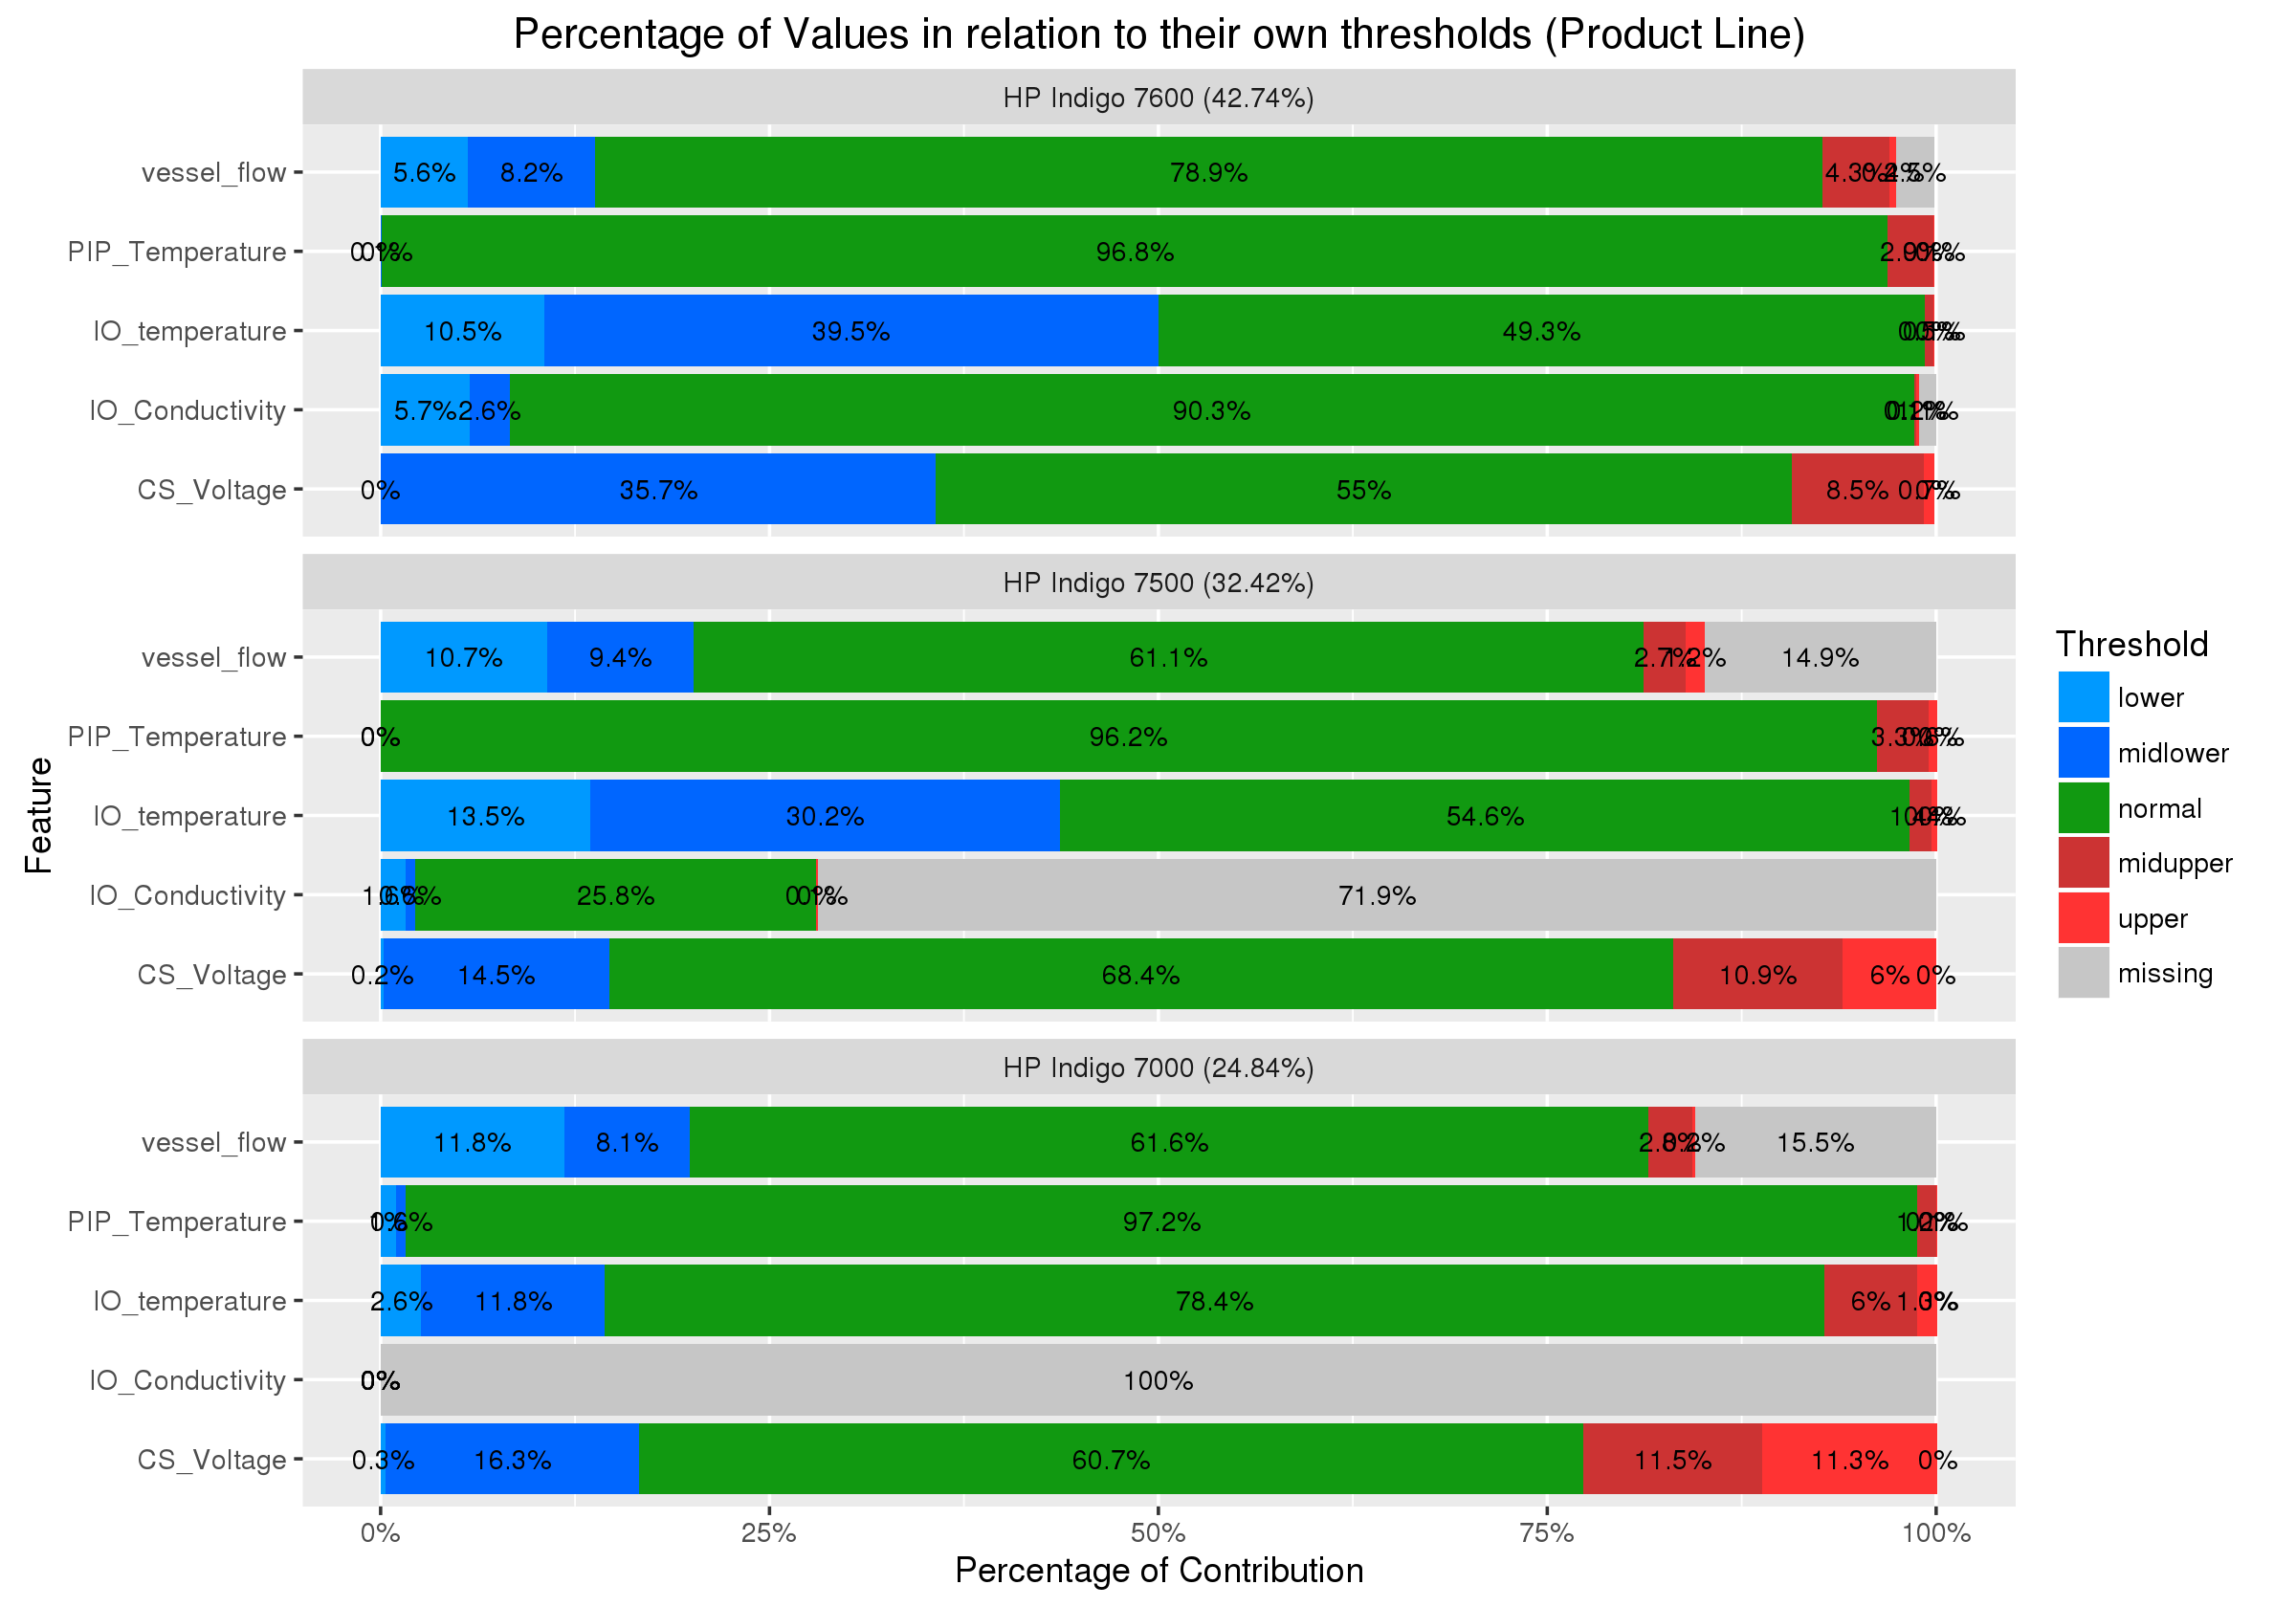

In [17]:
d9_pl <- d9_pl_totals %>% ungroup() %>%
                  mutate(Product_Line = as.character(Product_Line)) %>%
                  select(Product_Line, Count) %>% 
                  group_by(Product_Line) %>%
                  summarize(Count = min(Count),
                            Ratio = round(Count/nrow(d), 4)) %>%
                  arrange(desc(Ratio)) %>%
                  mutate(label = paste0(Product_Line, " (" , Ratio * 100, "%)"))

options(repr.plot.width=10, repr.plot.height = 7, repr.plot.res = 240)

d9_pl_totals %>% 
  ungroup() %>%
  mutate(Product_Line = factor(as.character(Product_Line), levels = d9_pl$Product_Line,
                                                           labels = d9_pl$label)) %>%
  ggplot(aes(x = Feature, y = Ratio, fill = Threshold)) +
  geom_bar(stat="identity") +
  scale_fill_manual(values=c("#0099FF","#0066FF", "#119911", "#CC3333", "#FF3333", "#C6C6C6")) +
  scale_y_continuous(labels = percent_format())+
  facet_wrap(~ Product_Line, nrow = 3) +
  geom_text(aes(x = Feature, y = Position, label = paste0(Ratio * 100, "%")), size = 3) +
  ylab("Percentage of Contribution") +
  ggtitle("Percentage of Values in relation to their own thresholds (Product Line)") +
  coord_flip()

In [18]:
d9_totals <- d9 %>% 
             group_by(Feature) %>%
             summarise(Count = n(),
                       lower.count = (Threshold == "lower") %>% sum(),
                       midlower.count = (Threshold == "midlower") %>% sum(),
                       normal.count = (Threshold == "normal") %>% sum(),
                       midupper.count = (Threshold == "midupper") %>% sum(),
                       upper.count = (Threshold == "upper") %>% sum(),
                       missing.count = (Threshold == "missing") %>% sum(),
                       lower.ratio = round(lower.count / Count, 3),
                       midlower.ratio = round(midlower.count / Count, 3),
                       normal.ratio = round(normal.count / Count, 3),
                       midupper.ratio = round(midupper.count / Count, 3),
                       upper.ratio = round(upper.count / Count, 3),
                       missing.ratio =round(missing.count / Count, 3)) %>%
             gather(key = Threshold, value = Ratio, ends_with(".ratio")) %>%
             mutate(Threshold = gsub(".ratio", "", Threshold)) %>%
             group_by(Feature) %>%
             mutate(Position = cumsum(Ratio) - (0.5 * Ratio), 
                    Threshold = factor(Threshold, levels = labels_missing,
                                                    labels = labels_missing,
                                                    ordered = T))

d9_totals %>% select(Feature, Threshold, Ratio) %>%
                 spread(key = Threshold, value = Ratio) %>% 
                 select( Feature, lower, midlower, normal, midupper, upper, missing) %>%
                 group_by(Feature)


,Feature,lower,midlower,normal,midupper,upper,missing
1,CS_Voltage,0.001,0.24,0.608,0.1,0.05,0
2,IO_Conductivity,0.03,0.013,0.469,0.001,0.001,0.486
3,IO_temperature,0.095,0.296,0.583,0.022,0.005,0
4,PIP_Temperature,0.003,0.002,0.967,0.026,0.003,0
5,vessel_flow,0.088,0.086,0.688,0.034,0.006,0.098


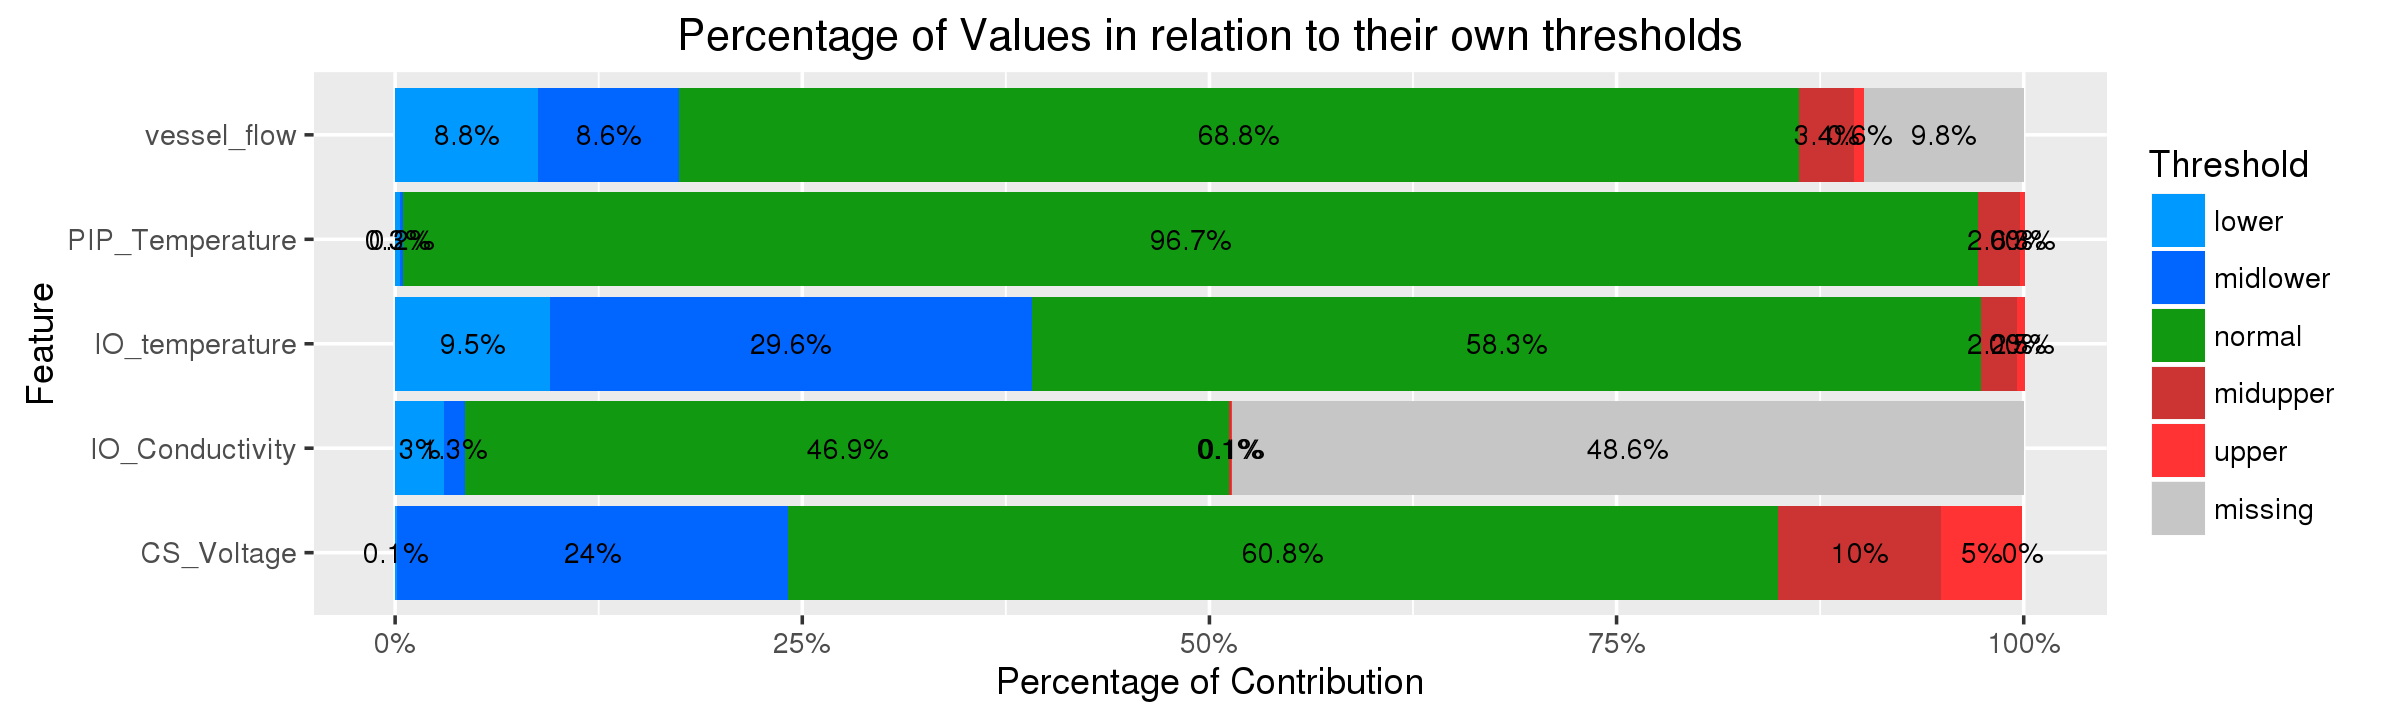

In [19]:
options(repr.plot.width=10, repr.plot.height = 3, repr.plot.res = 240)

d9_totals %>% ggplot(aes(x = Feature, y = Ratio, fill = Threshold)) +
  geom_bar(stat="identity") +
  scale_fill_manual(values=c("#0099FF","#0066FF", "#119911", "#CC3333", "#FF3333", "#C6C6C6")) +
  scale_y_continuous(labels = percent_format())+
  geom_text(aes(x = Feature, y = Position, label = paste0(Ratio * 100, "%")), size = 3) +
  ylab("Percentage of Contribution") +
  ggtitle("Percentage of Values in relation to their own thresholds") +
  coord_flip()

,SWv,Count,Ratio
1,V11_4_i40 I-Fix 1_i11,121958,0.5988
2,V11_2_i18,66313,0.3256
3,V11_4_i40,12261,0.0602
4,V8_6_3_i35 I-Fix 1_i4,1542,0.0076
5,V8_6_3_i35 I-Fix 2_i19,853,0.0042
6,V8_6_3_i35,183,9e-04
7,V8_6_1_i57,152,7e-04
8,V8_4_3_i30 I-Fix 2_i18,120,6e-04
9,V11_2_i14,95,5e-04
10,V12_0_i22,99,5e-04


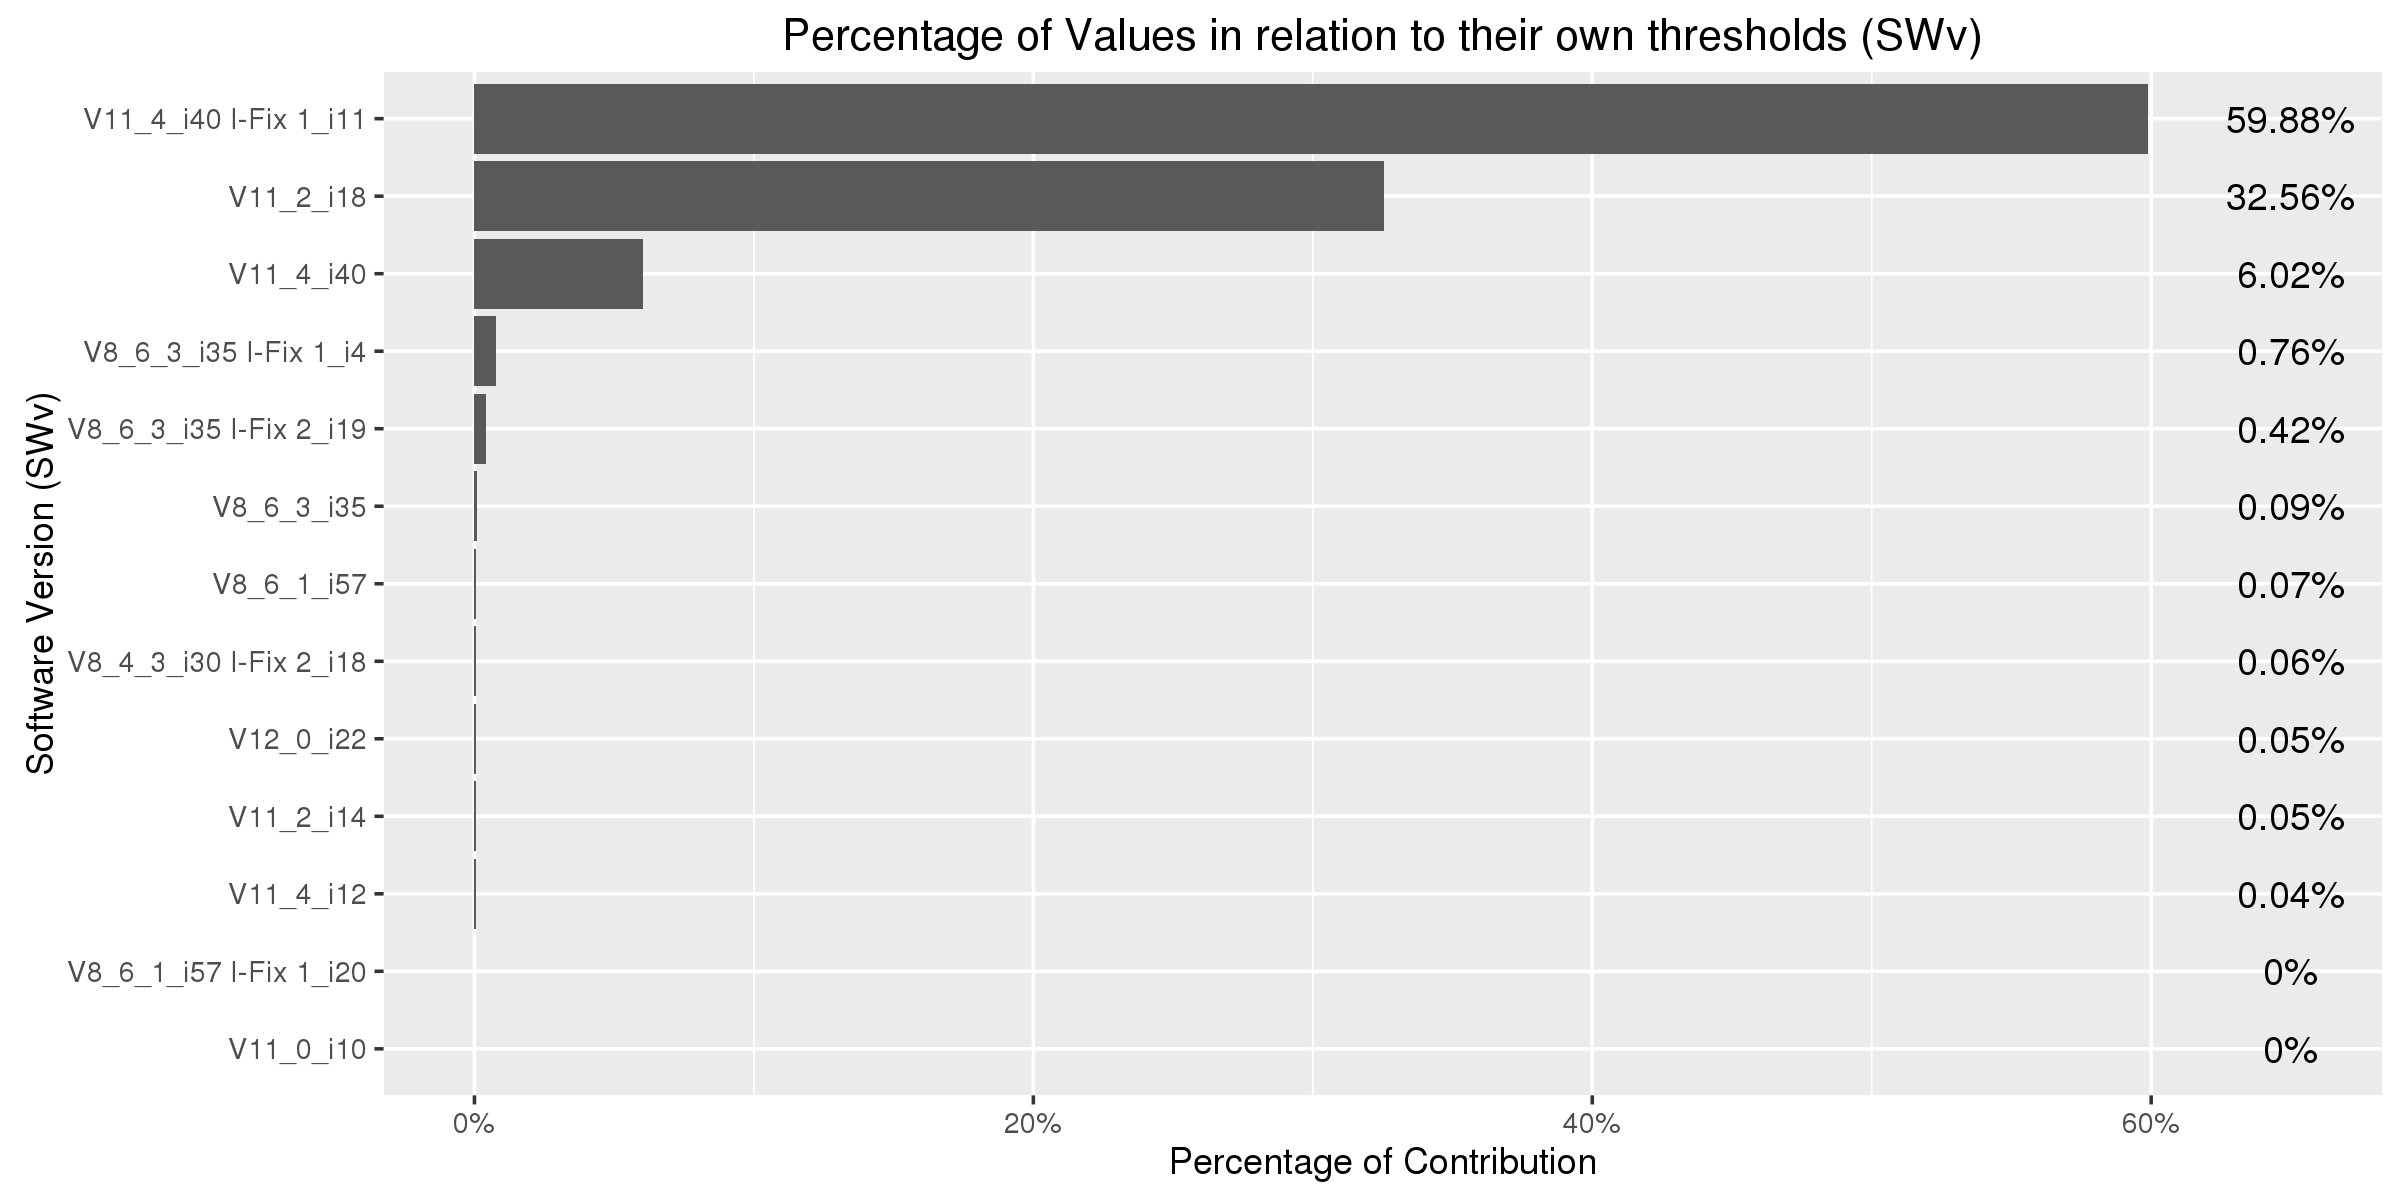

In [20]:

d9_swv_totals <- d9 %>% group_by(SWv, Feature) %>%
  summarise(Count = n(),
            lower.count = (Threshold == "lower") %>% sum(),
            midlower.count = (Threshold == "midlower") %>% sum(),
            normal.count = (Threshold == "normal") %>% sum(),
            midupper.count = (Threshold == "midupper") %>% sum(),
            upper.count = (Threshold == "upper") %>% sum(),
            missing.count = (Threshold == "missing") %>% sum(),
            lower.ratio = round(lower.count / Count, 3),
            midlower.ratio = round(midlower.count / Count, 3),
            normal.ratio = round(normal.count / Count, 3),
            midupper.ratio = round(midupper.count / Count, 3),
            upper.ratio = round(upper.count / Count, 3),
            missing.ratio =round(missing.count / Count, 3)) %>%
  gather(key = Threshold, value = Ratio, ends_with(".ratio")) %>%
  mutate(Threshold = gsub(".ratio", "", Threshold)) %>%
  group_by(SWv, Feature) %>%
  mutate(Position = cumsum(Ratio) - (0.5 * Ratio),
         Threshold = factor(Threshold, levels = labels_missing,
                            labels = labels_missing,
                            ordered = T))

d9_swv <- d9_swv_totals %>% ungroup() %>%
                  mutate(SWv = as.character(SWv)) %>%
                  select(SWv, Count) %>% 
                  group_by(SWv) %>%
                  summarize(Count = min(Count),
                            Ratio = round(Count/nrow(d), 4)) %>%
                  arrange(desc(Ratio)) %>%
                  mutate(label = paste0(SWv, " (" , Ratio * 100, "%)"))

d9_swv %>% select(-label)

options(repr.plot.width=10, repr.plot.height = 5, repr.plot.res = 240)
d9_swv %>% ggplot(aes(x = reorder(SWv, Ratio), y = Ratio)) +
           geom_bar(stat="identity") +
           geom_text(aes(x = SWv, y = 0.65, label = paste0(Ratio * 100, "%")), size = 4) +
           scale_y_continuous(labels = percent_format())+
           ylab("Percentage of Contribution") +
           xlab("Software Version (SWv)") +
           ggtitle("Percentage of Values in relation to their own thresholds (SWv)") +
           coord_flip()


Most of the Software Versions don't have enough numbers to be a proper representative sample. So the next plot shows the percentage of contribution for the 5 most representative versions. These 5 represent **99.64%** of all data.

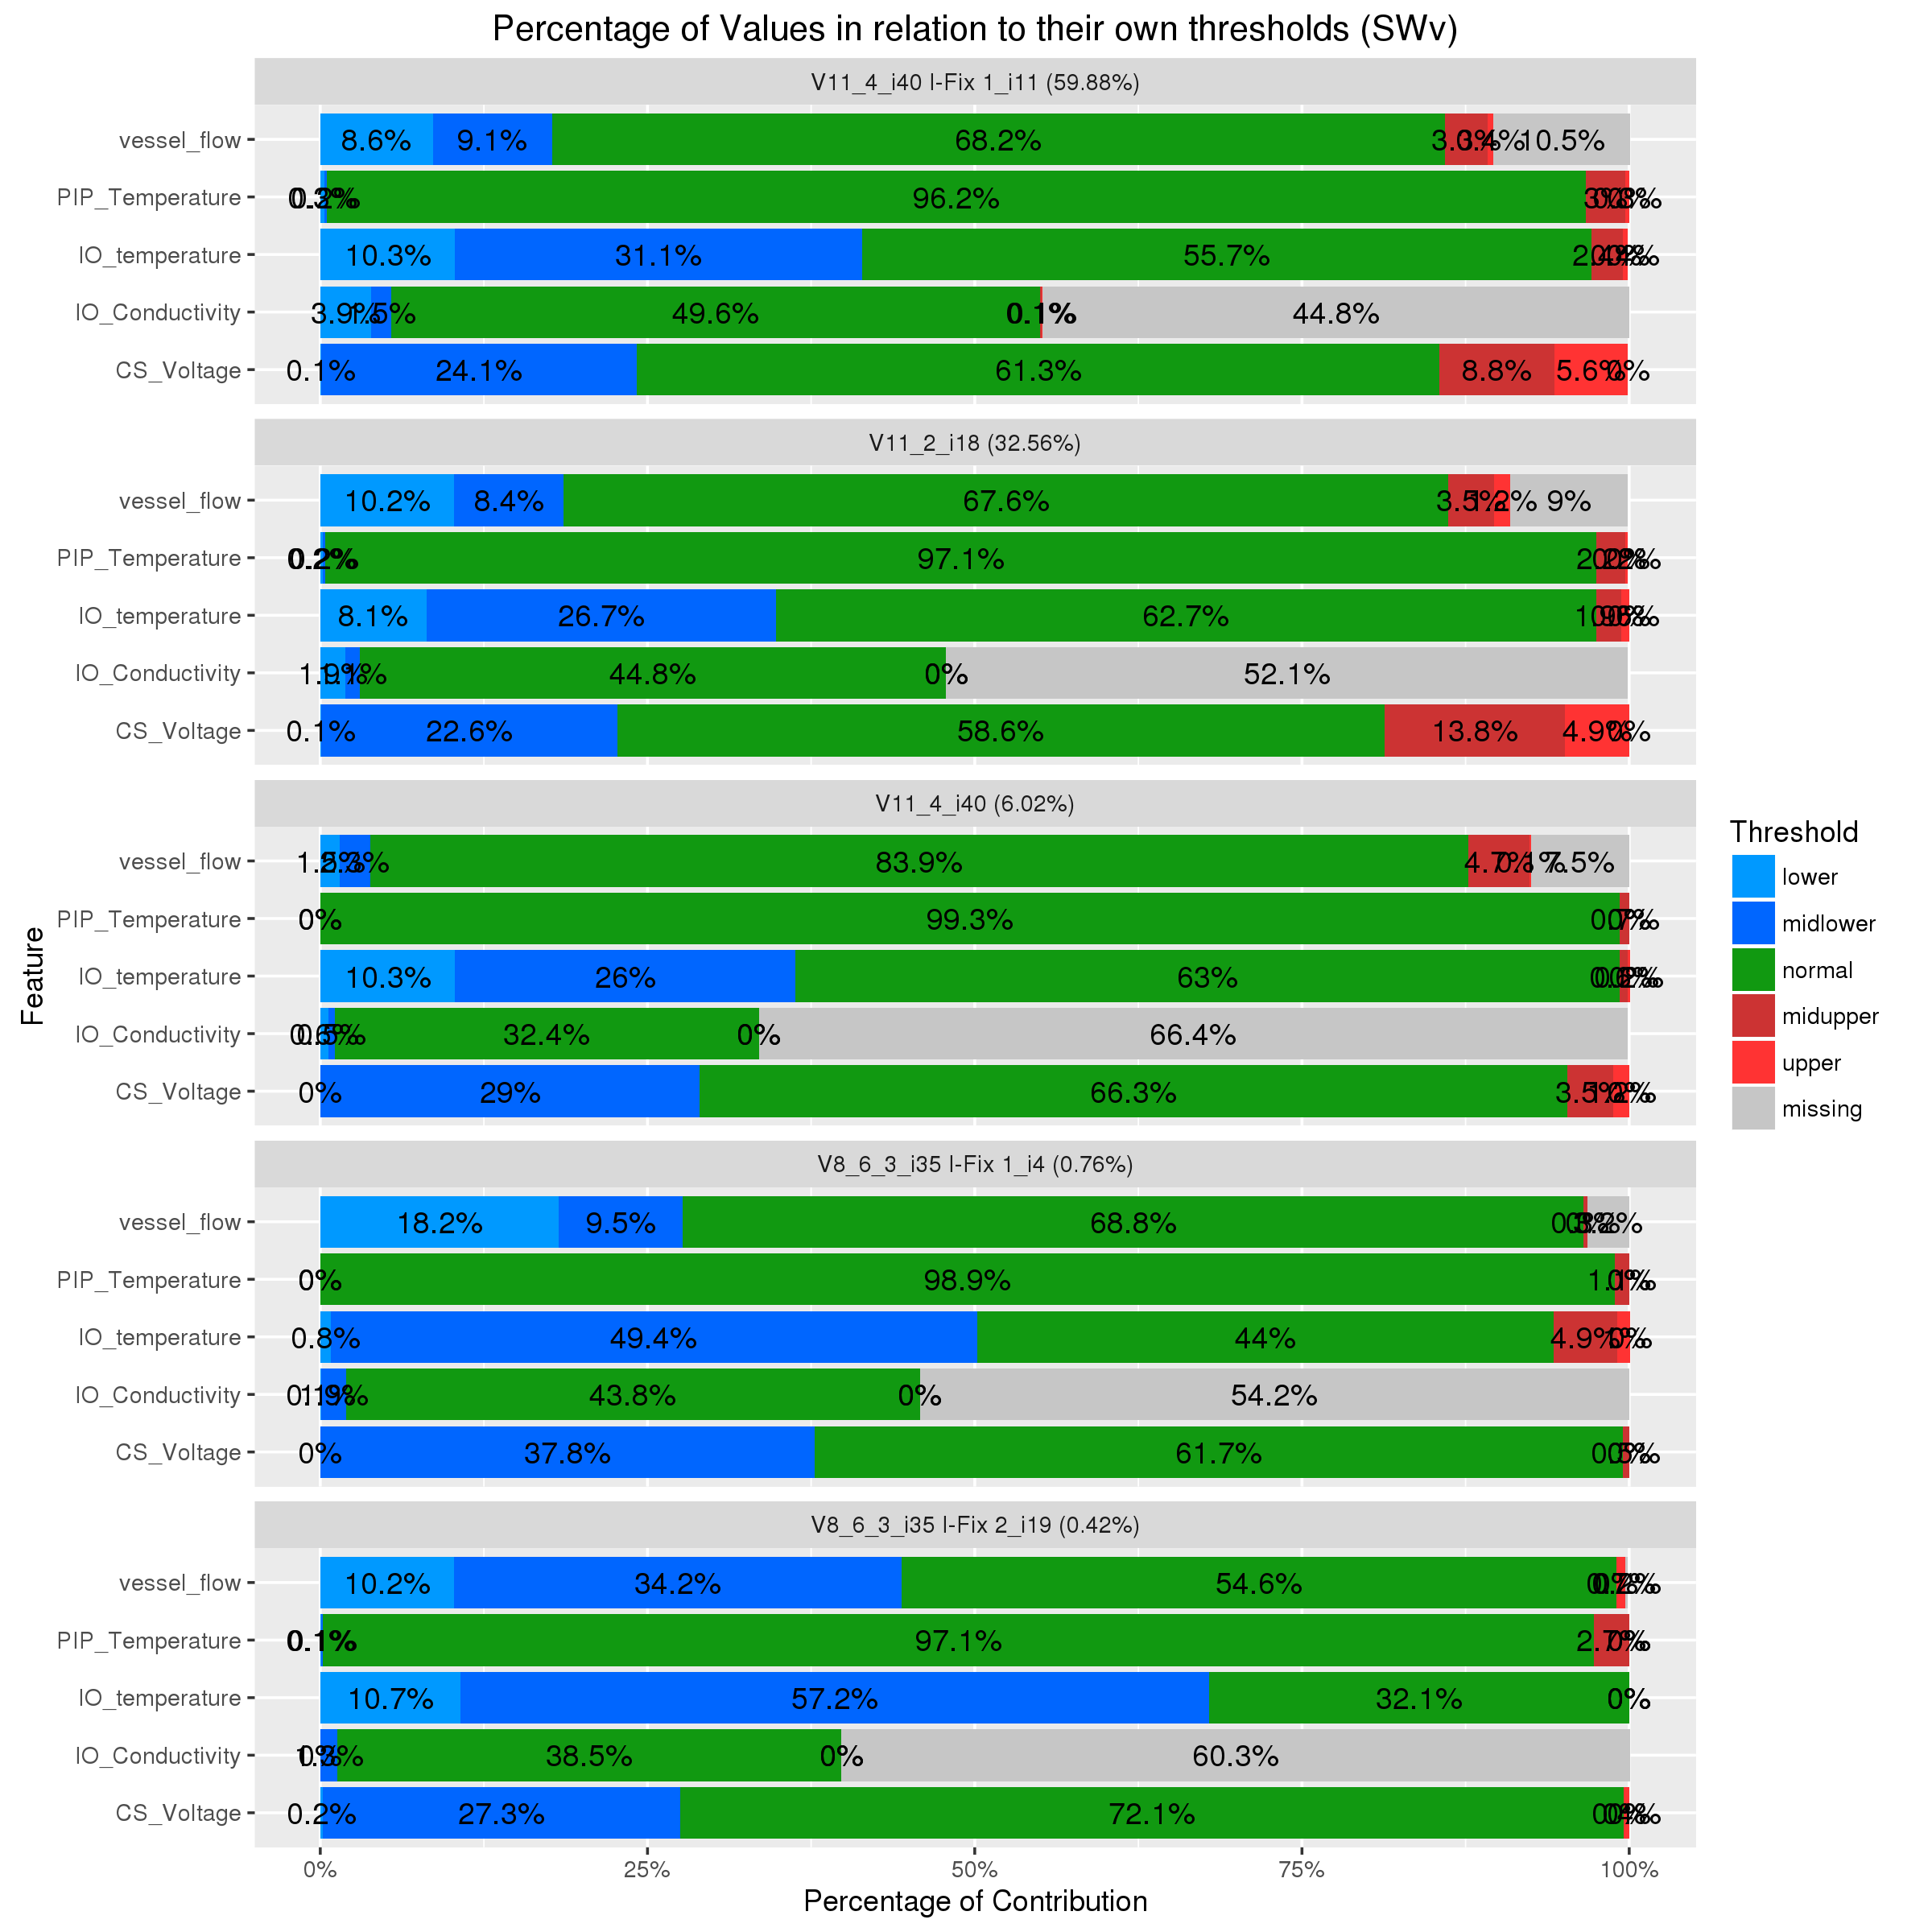

In [21]:
options(repr.plot.width=10, repr.plot.height = 10, repr.plot.res = 240)

d9_swv_totals %>% ungroup() %>%
  filter(SWv %in% d9_swv$SWv[1:5]) %>%
  mutate(SWv = factor(as.character(SWv), levels = d9_swv$SWv[1:5],
                                        labels = d9_swv$label[1:5])) %>%
  ggplot(aes(x = Feature, y = Ratio, fill = Threshold)) +
  geom_bar(stat="identity") +
  scale_fill_manual(values=c("#0099FF","#0066FF", "#119911", "#CC3333", "#FF3333", "#C6C6C6")) +
  scale_y_continuous(labels = percent_format())+
  facet_wrap(~ SWv, nrow = 5) +
  geom_text(aes(x = Feature, y = Position, label = paste0(Ratio * 100, "%")), size = 4) +
  ylab("Percentage of Contribution") +
  ggtitle("Percentage of Values in relation to their own thresholds (SWv)") +
  coord_flip()